In [1]:
%load_ext autoreload
%autoreload 2
import dgl
import sys
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
from src.convg import dgl_to_nx_graph
from src.balls import BallDistances
from src.baseline_models import train_knn, train_perceptron, train_rst, train_mv
from src.vcbases import retrieve_ball_bases, train_model, retrieve_hier_bases, retrieve_interval_bases, retrieve_lvc_bases_peeling, train_model_space_efficient
from src.utils import inject_noise

cora_dataset = dgl.data.CoraGraphDataset()
cora_graph, cora_labels = dgl_to_nx_graph(cora_dataset)

cora_graph = nx.Graph(cora_graph)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [2]:
largest_cc = max(nx.connected_components(cora_graph), key=len)
testg = cora_graph.subgraph(largest_cc)
testg_labels = [testg.nodes[node]['label'] for node in testg.nodes]

# Relable nodes in incremental order
testg = nx.relabel_nodes(testg, {n: i for i, n in enumerate(testg.nodes())})
for e in testg.edges:
    testg.edges[e]['capacity'] = 1.0
print(testg)

Graph with 2485 nodes and 5069 edges


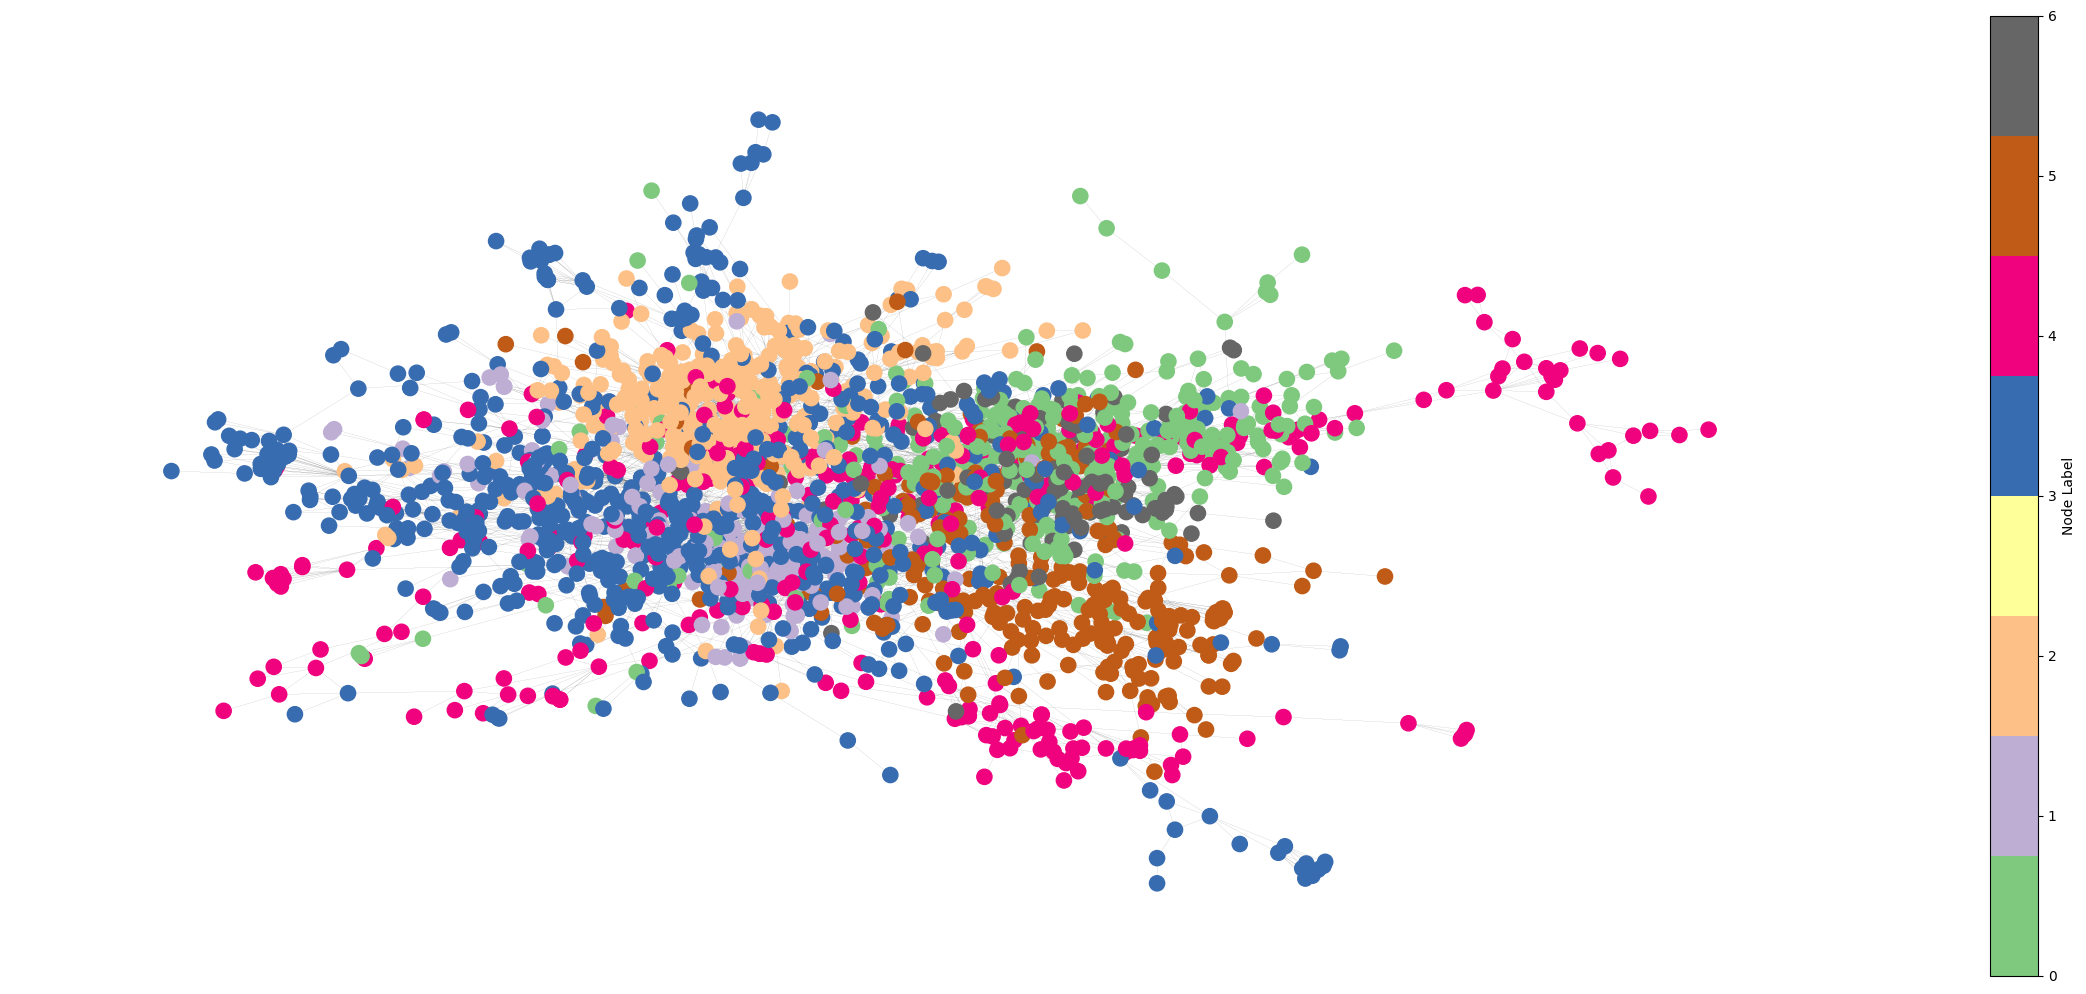

In [3]:
from src.utils import render_graph

render_graph(testg)

In [3]:
import time

In [4]:
tmp = time.time()
balls = BallDistances(testg, initialize_sp=False, initialize_edp=False, initialize_pinv=False, disable = True)
tolerance = 0.001
d1_bases, n2b_d1 = retrieve_ball_bases(testg, balls.d1_ball_distance, disable=True)
d2_bases, n2b_d2 = retrieve_ball_bases(testg, balls.d2_ball_distance, disable=True, log_balls = True)
dinf_bases, n2b_dinf = retrieve_ball_bases(testg, balls.dinf_ball_distance, disable=True)
lvc_bases, n2b_lvc = retrieve_lvc_bases_peeling(testg,disable=True)
int_bases, n2b_int = retrieve_interval_bases(testg, disable = True)
tmp = time.time() - tmp
print("RETRIEVING BALLS: ", tmp)

RETRIEVING BALLS:  2257.244699716568


In [176]:
%%time
import pickle
from src.utils import relabel_graph, create_noise_graph, create_noise_graph_perc
import random
import time
from tqdm.auto import tqdm
from collections import defaultdict
from src.bandits import train_bandit
from src.GABA import train_gaba
from src.contextualsimilarity import train_cont
from src.exp3 import train_exp3

tmp_train = time.time()

epochs = 1
seed_list = random.choices(list(range(1000)),k = 15)
cora_seeds = 5
NOISE_LABELS = 3
PERC_NOISE_FOREGROUND = 0.2

rows_df = []
rows_names = []

labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
random.seed(32)
rsl = [set(random.sample(range(len(labels_set)), NOISE_LABELS)) for _ in range(cora_seeds)]

plt_np_arr = {
    frozenset(r) : dict() for r in rsl
}
print(rsl)
###############################################################
for random_set_label in tqdm(rsl, desc="Cora_seeds..."):
    ## Create the graph from cora
    testg = cora_graph.subgraph(largest_cc)
    # Relable nodes in incremental order
    testg = nx.relabel_nodes(testg, {n: i for i, n in enumerate(testg.nodes())})
    labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
    for e in testg.edges:
        testg.edges[e]['capacity'] = 1.0
    #testg = nx.path_graph(50)
    #for n in testg.nodes:
    #    testg.nodes[n]['label'] = n%7
    #nx.set_edge_attributes(testg, 1.0, 'capacity')
    # Random select a subset of NOISELABELS labels to make as noise
    print("Making noisy the labels: ", random_set_label)
    testg = create_noise_graph(testg, random_set_label)
    testg = relabel_graph(testg)
    #############################################################
    bases_list = [(d1_bases, n2b_d1, "D1"), 
                  (d2_bases, n2b_d2, "D2"), 
                  (dinf_bases, n2b_dinf, "D-INF"), 
                  (lvc_bases, n2b_lvc, "LVC"), 
                  (int_bases, n2b_int, "INT")]
    
    # Squared number of nodes (at least 2 times for each node)
    T = len(testg.nodes)*10
    print(T)
    
    curr_labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
    K_classes = len(curr_labels_set) - 1
    res_list = defaultdict(lambda : [])
    res_plot = defaultdict(lambda : [])
    for seed in tqdm(seed_list, desc="Epochs"):    
        ##############################################################################
        ######################### TRAINING ###########################################
        ##############################################################################
        loss_perc = .8
        verbose = False
        for base, n2b, name in bases_list:
            res, _ = train_bandit(testg, 
                base,
                n2b,
                T,
                K_classes,
                loss_percentage = loss_perc,
                seed = seed,
                verbose = verbose,
                name=name,
                disable_tqdm_train = True, debug = True)
            res_list[name] += [res[0]/T]
            res_plot[name] += [np.array(res[1])]
            
        res_gaba, _ = train_gaba(
            testg, 
            T, 
            K_classes + 1, 
            eta = 0.07,
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["GABA"] += [res_gaba[0]/T]
        res_plot["GABA"] += [np.array(res_gaba[1])]
        
        res_cbs, _ = train_cont(
            testg, 
            T, 
            K_classes + 1, 
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["CBSim"] += [res_cbs[0]/T]
        res_plot["CBSim"] += [np.array(res_cbs[1])]
        
        res_exp3, _ = train_exp3(
            testg, 
            T, 
            K_classes + 1, 
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["EXP3"] += [res_exp3[0]/T]
        res_plot["EXP3"] += [np.array(res_exp3[1])]

    rate_list = [np.mean(r_l) for _,r_l in res_list.items()]
    std_list = [np.std(r_l) for _,r_l in res_list.items()]
    
    for lab, plot in res_plot.items(): 
        plt_np_arr[frozenset(random_set_label)][lab] = plot
    
    rows_df += [rate_list]
    rows_names += [f'Mean{random}']
    rows_df += [std_list]
    rows_names += [f'Std{random_set_label}']
    
    ###################################################

tmp_train = time.time() - tmp_train

#base_model_names = res_list.keys()
#res_df = pd.DataFrame(columns=base_model_names)
#for ind,row in enumerate(rows_df):
#    res_df.loc[ind] = row
#res_df.index = rows_names
#
#res_df

[{0, 1, 4}, {1, 2, 3}, {0, 3, 4}, {0, 2, 4}, {1, 3, 4}]


Cora_seeds...:   0%|          | 0/5 [00:00<?, ?it/s]

Making noisy the labels:  {0, 1, 4}
24850


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Making noisy the labels:  {1, 2, 3}
24850


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Making noisy the labels:  {0, 3, 4}
24850


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Making noisy the labels:  {0, 2, 4}
24850


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Making noisy the labels:  {1, 3, 4}
24850


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 12h 38min 59s, sys: 14.3 s, total: 12h 39min 13s
Wall time: 12h 40min 16s


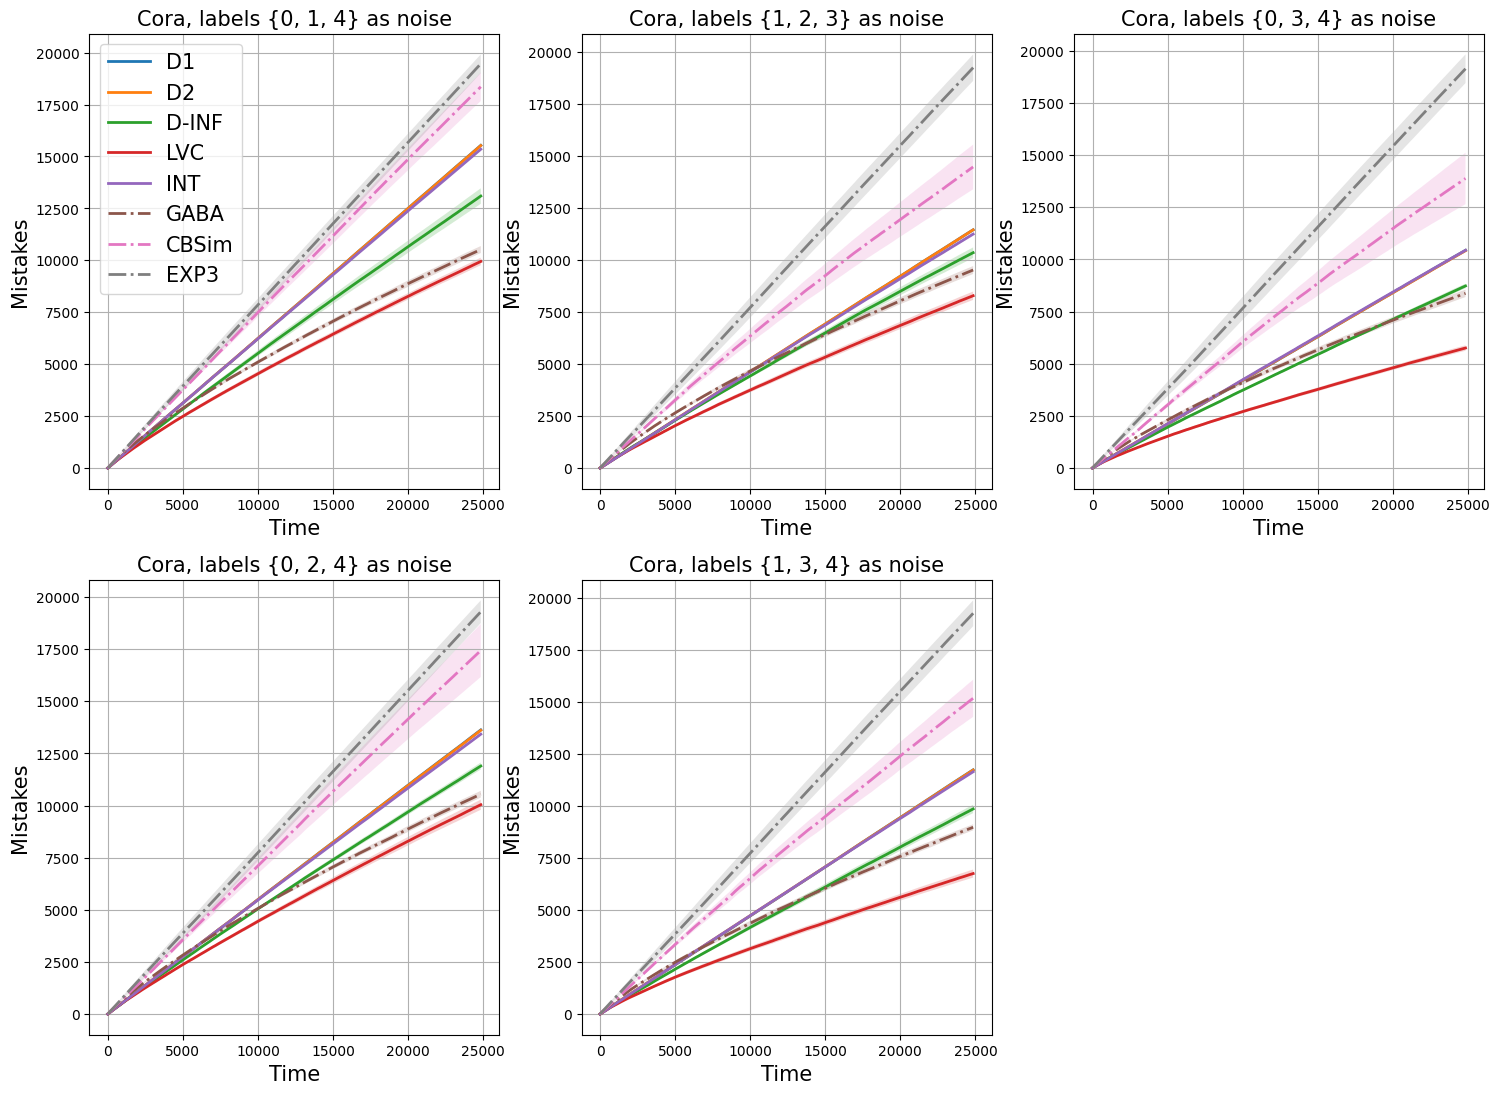

In [181]:
from src.utils import render_plot_CI, get_average_plot_cora

test_loaded_plot = (input_list, plt_np_arr)

render_plot_CI(test_loaded_plot,2,3, figx=18, figy=13, save_fig=True, path = 'results/cora/all_cora.svg')

In [ ]:
get_average_plot_cora(loaded_data, 'results/cora/TOTAL.pdf')